In [1]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
print("GPUs available:", physical_devices)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
from functools import partial
import math
import numpy as np

from ocml.datasets import load_toy_2d, default_process, build_ds_from_numpy, tfds_from_sampler
from ocml.evaluate import check_LLC, log_metrics
from ocml.models import conventional_dense, spectral_dense
from ocml.plot import plot_3d
from ocml.priors import uniform_tabular
from ocml.train import train, SH_KR, BCE

Perlin noise not available. Please install perlin_numpy package with `pip3 install git+https://github.com/pvigier/perlin-numpy`.


In [37]:
from types import SimpleNamespace

def get_config(debug=False):
  # bathtub
  # bed
  # chair
  # desk
  # dresser
  # monitor
  # night_stand
  # sofa
  # table
  # toilet
  model_name = 'bathtub'
  model_num = '0004'
  config = SimpleNamespace(
    dataset_name = "modelnet",
    model_name = f'{model_name}/train/{model_name}_{model_num}.off',
    optimizer = 'rmsprop',  # optimizer; good default value.
    batch_size = 1024,  # should be not too small to ensure diversity.
    domain = [-3, 3],  # domain on which to sample points.
    maxiter = 8,  # very important on high dimensional dataset.
    eta = 4.,  # stepsize multiplier to help convergence.
    margin = 0.05,  # very important !
    points_to_sample = 2048,  # number of points to smple form the mesh
    lbda = 100.,  # important but not as much as `margin`. Must be high for best results.
    k_coef_lip = 1.,  # no reason to change this.
    spectral_dense = True,  # Mandatory for orthogonal networks. 
    deterministic = False,  # Better with random learning rates.
    conventional = False,  # Conventional training (i.e without hKR and Lipschitz constraint) for sanity check.
    widths = [512, 512, 512, 512],
    warmup_epochs = 10,
    epochs_per_plot = 15,
    epoch_length = 250
  )
  return config

In [38]:
debug = True
config = get_config(debug)
train_kwargs = {
  'domain': config.domain,
  'deterministic': config.deterministic,
  'overshoot_boundary': True,
  'eta': config.eta
}

In [39]:
try:
  import os
  os.environ['WANDB_NOTEBOOK_NAME'] = 'run_sdf.ipynb'
  import wandb
  wandb.login()
  wandb_available = True
except ModuleNotFoundError as e:
  print(e)
  print("Wandb logs will be removed.")
  wandb_available = False
plot_wandb = wandb_available and not debug  # Set to False to de-activate Wandb.
if plot_wandb:  
  import wandb
  wandb.init(project="shapenet_sdf", config=config.__dict__)
else:
  try:
    wandb.finish()
  except Exception as e:
    print(e)
    
train_kwargs['log_metrics_fn'] = partial(log_metrics, plot_wandb=plot_wandb)

In [40]:
# Train model.
if config.conventional:
  model = conventional_dense(widths=config.widths, input_shape=(3,))
else:
  model = spectral_dense(widths=config.widths, input_shape=(3,),
                         k_coef_lip=config.k_coef_lip)

if config.conventional:
  loss_fn = BCE()
else:
  loss_fn = SH_KR(config.margin, config.lbda)

In [41]:
import glob
import os
import trimesh
import shutil

download = False
if download:
  to_remove = "/data/datasets/modelnet/"
  if os.path.isdir(to_remove):
      shutil.rmtree(to_remove)
  else:
      print("Error: %s folder not found" % to_remove)
  DATA_DIR = tf.keras.utils.get_file(
    "ModelNet10.zip",
    "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip",
    cache_subdir='/data/datasets/modelnet/',
    cache_dir='/data/datasets/modelnet/',
    extract=True,
  )
  DATA_DIR = os.path.join(os.path.dirname(DATA_DIR), "ModelNet10")

In [42]:
file_name = os.path.join('/data/datasets/modelnet/ModelNet10/', config.model_name)
mesh = trimesh.load(file_name)
points = mesh.sample(config.points_to_sample)
mesh.show()  

In [43]:
import matplotlib.pyplot as plt

print(f"Min={points.min()} Max={points.max()}")
points = (points - points.mean(axis=0, keepdims=True)) / np.std(points.flatten())
print(f"Min={points.min()} Max={points.max()}")
p_dataset = build_ds_from_numpy(points, config.batch_size)

Min=-30.50002 Max=30.50002
Min=-1.9849050166128253 Max=2.0015291213040025


In [44]:
np.savetxt('weights/points.txt', points, delimiter=', ')

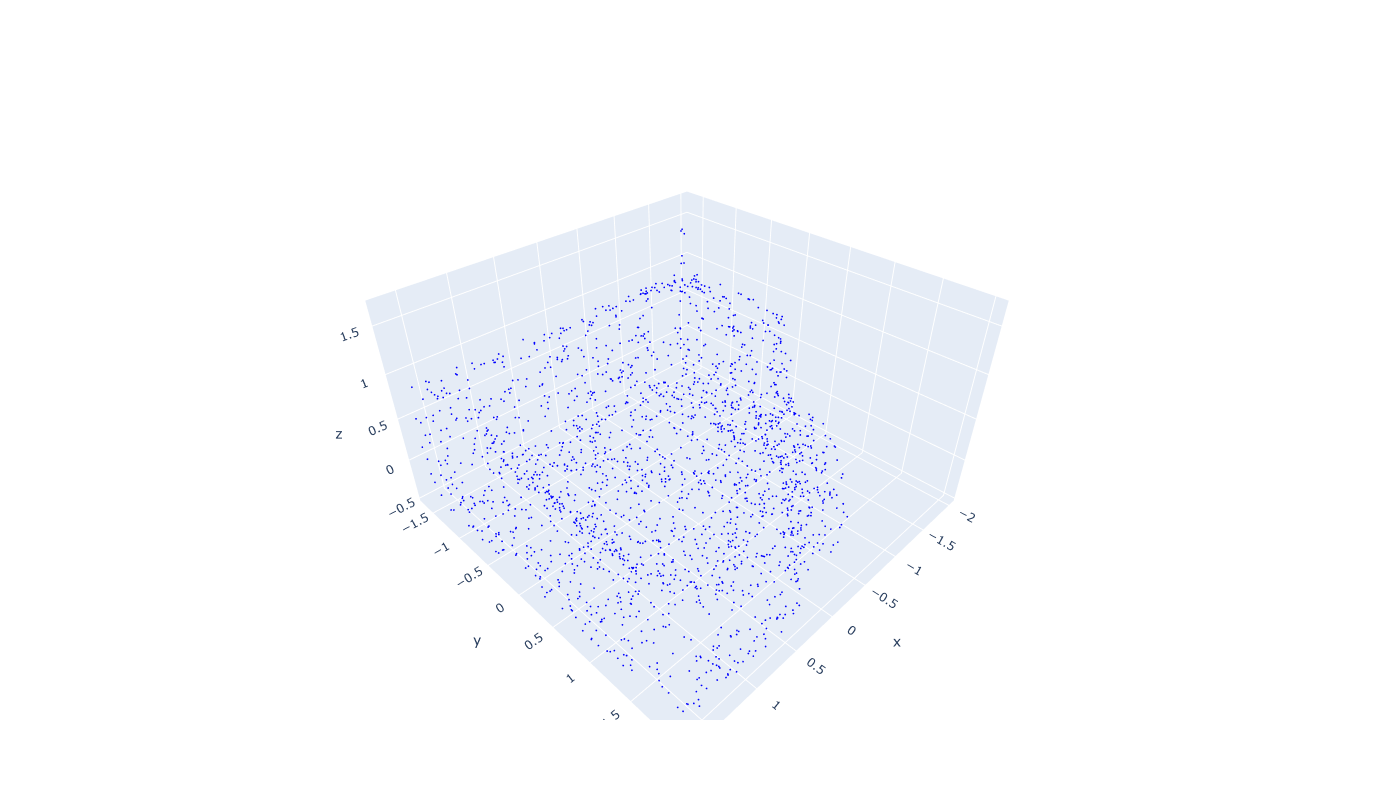

In [52]:
import plotly.graph_objects as go
aspect = (np.ptp(points[:, 0]), np.ptp(points[:, 1]), np.ptp(points[:, 2]))
fig = go.Figure(data=[go.Scatter3d(x=points[:, 0], y=points[:, 1], z=points[:, 2], mode='markers', marker_color='blue', marker_size=1.)])
fig.update_layout(
    autosize=False,
    width=800,
    height=800)
filename = "images/cloud3D.png"
fig.write_image(filename)
if plot_wandb:
  wandb.save(filename)
fig

In [46]:
def ds_from_shapenet():
  from tfg.datasets.shapenet import Shapenet
  dl_config = {'download_config': tfds.download.DownloadConfig(manual_dir='/data/datasets/shapenet_base/')}
  ds = Shapenet.load(split='train', download_and_prepare_kwargs=dl_config)
  # TODO: complete this.
  return ds

In [47]:
# Create optimizer.
opt =  tf.keras.optimizers.get(config.optimizer)

# Initialize the network.
gen = tf.random.Generator.from_seed(4321)  # reproducible sampling.
p_batch = next(iter(p_dataset))
_ = model(p_batch, training=True)  # dummy forward to trigger initialization.
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
spectral_dense_16 (SpectralD (None, 512)               4097      
_________________________________________________________________
full_sort_16 (FullSort)      (None, 512)               0         
_________________________________________________________________
spectral_dense_17 (SpectralD (None, 512)               525313    
_________________________________________________________________
full_sort_17 (FullSort)      (None, 512)               0         
_________________________________________________________________
spectral_dense_18 (SpectralD (None, 512)               525313    
_________________________________________________________________
full_sort_18 (FullSort)      (None, 512)               0         
_________________________________________________________________
spectral_dense_19 (SpectralD (None, 512)              

In [48]:
# Adversarial distribution.
q_dataset = tfds_from_sampler(uniform_tabular, gen, config.batch_size, p_batch.shape[1:], domain=config.domain)
Q0 = next(iter(q_dataset))

S=1.0000001192092896 2-inf=[('0.007295052520930767', '0.16222040355205536')] inf=[('0.011220629326999187', '0.26096272468566895')] 2=[(1.0, 1.0000001)]
S=1.0000007152557373 2-inf=[('0.9999998807907104', '1.0000001192092896')] inf=[('17.216535568237305', '18.650850296020508')] 2=[(0.9999994, 1.0000007)]
S=1.000001072883606 2-inf=[('0.9999998807907104', '1.0000001192092896')] inf=[('17.49773597717285', '18.694313049316406')] 2=[(0.99999905, 1.0000011)]
S=1.0000008344650269 2-inf=[('0.9999998807907104', '1.0000001192092896')] inf=[('17.374958038330078', '18.767576217651367')] 2=[(0.9999989, 1.0000008)]
Example n°685 from train set has norm 0.1865750402212143.
max_i \|nabla_x f(x_i)\|: tf.Tensor([[0.18657506]], shape=(1, 1), dtype=float32)
LLC = Local Lipschitz Constant
Input, LLC wrt Input, LLC wrt previous layer
Input_Norms 0.0018657366960119744 0.0018657366960119744
spectral_dense_16 0 <class 'deel.lip.layers.SpectralDense'> 1.00 1.00
full_sort_16 1 <class 'deel.lip.activations.FullSort

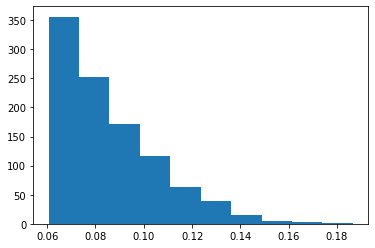

In [49]:
check_LLC(model, Q0, plot_wandb)

In [51]:
num_epochs = config.warmup_epochs
for epoch in range(num_epochs):
  train(model, opt, loss_fn, gen, p_dataset, q_dataset, config.epoch_length, maxiter=0, **train_kwargs)

 52%|█████▏    | 130/250 [00:11<00:10, 11.82it/s, FP=0.14%, GN_Qt=0.000, P=0.063, Q0=-0.444, Qt=-0.444, R=0.99%, lipschitz_ratio=1.000, loss=0.015]


KeyboardInterrupt: 

In [ ]:
plot_3d(model, points, domain=config.domain, q=0., grid_res=100, modes='ratio', plot_backend='trimesh')

In [ ]:
for epoch in range(config.epochs_per_plot):
  train(model, opt, loss_fn, gen, p_dataset, q_dataset, config.epoch_length, maxiter=config.maxiter, **train_kwargs)

In [ ]:
plot_3d(model, points, domain=config.domain, q=0., grid_res=100, modes='ratio', plot_backend='trimesh')

In [ ]:
for epoch in range(config.epochs_per_plot):
  train(model, opt, loss_fn, gen, p_dataset, q_dataset, config.epoch_length, maxiter=config.maxiter, **train_kwargs)

In [ ]:
plot_3d(model, points, domain=config.domain, q=0., grid_res=100, modes='ratio', plot_backend='trimesh')

In [ ]:
plot_3d(model, points, domain=config.domain, q=1e-2, grid_res=100, modes='ratio', plot_backend='trimesh')

In [ ]:
plot_3d(model, points, domain=config.domain, q=2e-2, grid_res=100, modes='ratio', plot_backend='trimesh')

In [ ]:
plot_3d(model, points, domain=config.domain, q=3e-2, grid_res=100, modes='ratio', plot_backend='trimesh')

In [ ]:
plot_3d(model, points, domain=config.domain, q=5e-2, grid_res=100, modes='ratio', plot_backend='trimesh')

In [ ]:
plot_3d(model, points, domain=config.domain, q=1e-1, grid_res=100, modes='ratio', plot_backend='trimesh')

In [ ]:
plot_3d(model, points, domain=config.domain, q=2e-1, grid_res=100, modes='ratio', plot_backend='trimesh')

In [ ]:
plot_3d(model, points, domain=config.domain, q=3e-1, grid_res=100, modes='ratio', plot_backend='trimesh')